## Dataset Generation

### Collecting hold data

In [1]:
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def plot_image(img,cvt=True):
    if cvt:
        if len(img.shape) == 2:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img)
    
# e.g. corners = [(2.0, 1.0), (4.0, 5.0), (7.0, 8.0)]
def polygonal_area(corners):
    n = len(corners) # of corners
    area = 0.0
    for i in range(n):
        j = (i + 1) % n
        area += corners[i][0] * corners[j][1]
        area -= corners[j][0] * corners[i][1]
    area = abs(area) / 2.0
    return area

def read_json(path):
    with open(path) as f:
        json_data = json.load(f)
        hold = json_data["shapes"][0]
        hold_area = polygonal_area(hold["points"])
        
def show_image(img,cvt=True):
    if cvt:
        if len(img.shape) == 2:
            cv2.imshow('img',img)
        else:
            cv2.imshow('img',cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
         cv2.imshow('img',img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()       
    
        
def resize_image(image, width=750, inter=cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))

    return cv2.resize(image, dim, interpolation=inter)
        


In [3]:

#plot_image(img_src)
#read_json('slab_images/image (1).json')

### Climbing hold dot detection

In [4]:
def ratio(n1, n2):
  """Calculates similarity score between 2 numbers
  Args:
      n1 (int): first number
      n2 (int): second number
  Returns:
      (float): similarity score between the 2 numbers
  """
  return 1 - abs(n1 - n2) / (n1 + n2)

def subimage_from_coords(img_src,x1,y1,x2,y2):
    return img_src[y1:y2,x1:x2]

def percentage_dark(img_src,threshold):
    num_dark = np.sum(img_src < threshold)
    num_light =  np.sum(img_src >= threshold)
    return num_dark/(num_light+num_dark)

def find_dots(img_src):
    """Climbing dot detection using connected component analysis
    Args:
        img_src (Mat): the image source
    Returns:
        dot_centres (list): list of (x,y) coordinates of the climbing dots
    """    
    # Create grayscale image
    gray_img = cv2.cvtColor(img_src, cv2.COLOR_BGR2GRAY)

    # Threshold search area
    binary_img = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY_INV, 131, 15)
    
    # Blob detection
    _, _, boxes, _ = cv2.connectedComponentsWithStats(binary_img)
    
    # First box is the background
    boxes = boxes[1:]
    
    # Threshold blobs by pixel area and percentage of dark pixels
    filtered_boxes = []
    for x,y,w,h,pixels in boxes:
        area_limit = (80 < pixels < 400)
        subimage = subimage_from_coords(gray_img,x,y,x+w,y+h)
        p = percentage_dark(subimage,80)
        p_limit = 0.4 < p < 0.6
        if p_limit and area_limit and ratio(w,h) > 0.75:
            filtered_boxes.append((x,y,w,h))

    # Create list of dot centres
    dot_centres = []
    for x,y,w,h in filtered_boxes:
        cv2.rectangle(img_src, (x,y), (x+w,y+h), (0,255,0),2) # draw rectangle around the detected dots
        dot_centre = (round(x+(w/2)),round(y+(h/2)))
        dot_centres.append(dot_centre)
        
    return dot_centres

In [5]:
from scipy import spatial
from statistics import mode
from collections import defaultdict
import math


def modal_distance(dot_centres):
    """Returns the modal distance between a list of (x,y) coordinates
    Args:
        dot_centres (list): list of (x,y) coordinates of the climbing dots
    Returns:
        avg (int): the modal distance
    """
    modal_distance_map = defaultdict(list)
    distances = []
    for dot_centre in dot_centres:
        # Create list of coordinates that excludes the current iterated coordinate
        other_centres = dot_centres
        other_centres.remove(dot_centre)
        # Kd-tree for quick nearest-neighbor lookup
        tree = spatial.KDTree(other_centres)
        # Append shortest distance to list of distances
        dist, idx = tree.query(dot_centre)
        rounded_dist = round(dist,-1)
        modal_distance_map[rounded_dist].append(dist)
    
    modal_distance = max(modal_distance_map, key=lambda key: len(modal_distance_map[key]))
    dists = modal_distance_map[modal_distance]
    return np.mean(dists)
    #avg = mode(distances)
    #return avg

img_src = cv2.imread('slab_images/image (90).jpeg')
dot_centres = find_dots(img_src)
dist = modal_distance(dot_centres)
cv2.line(img_src, (400,400), (400,400+round(dist)), (255,0,0), 5)
#show_image(resize_image(img_src))
print(f"cm/pixel: {20/dist}")
    

cm/pixel: 0.11770987417480978


### Route detection and sequencing

6


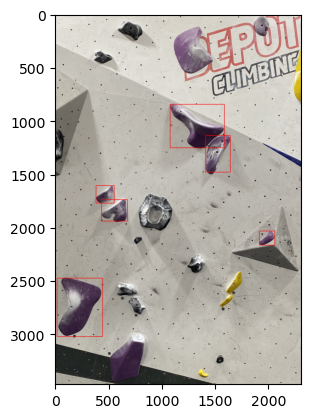

In [81]:
from itertools import combinations
import colorsys
import numpy as np
import scipy.cluster
import pickle

classes = np.array(['jug','easy_foothold','sloper','large_sloper','easy_edge','crimp_edge','edge_large_sloper','crimp','double_sided_jug','pinch_sloper','foothold','double_sided_sloper','curve_edge_sloper','edge','pocket','pinch','edge_sloper','volume','large_moon_edge','platform','u_edge'])

def rgb_trueblack(rgb_values):
    """Check if the given RGB value is very close to the blackest black
    Args:
        rgb_values (tuple): (r, g, b)
    Returns:
        boolean: True if the given RGB value is very close to the blackest black
    """
    return (np.mean(rgb_values) <= 10)

def rgb_kmeans(img,num_clusters):
    """Perform K-Means clustering on an image with a specified number of clusters
    Args:
        img (Mat): input image
        num_clusters (int): number of clusters (K) for K-Means
    Returns:
        rgb_centres, index_max (tuple): rgb values for centres of clusters, index of the rgb centre with the highest frequency
    """
    # Re-format img
    ar = np.asarray(img)
    shape = ar.shape
    ar = ar.reshape(np.product(shape[:2]), shape[2]).astype(float)
    
    # Perform K-Means clustering
    rgb_centres, _ = scipy.cluster.vq.kmeans(ar, num_clusters)
    rgb_centres = [c for c in rgb_centres if not rgb_trueblack(c)]
    vecs, _ = scipy.cluster.vq.vq(ar, rgb_centres)
    counts, bins = np.histogram(vecs, len(rgb_centres))
    
    # Index of the RGB array which holds the highest frequency
    index_max = np.argmax(counts)
    
    return (rgb_centres,index_max)

def rgb_similar(rgb_array,threshold=8):
    """Check if the R,G,B values in a given RGB array are similar to each other
    Args:
        rgb_array (array-like): (r,g,b)
        threshold: absolute difference threshold
    Returns:
        boolean: True if the R,G,B values in a given RGB array are similar to each other
    """
    abs_differences = [abs(a-b) for a, b in combinations(rgb_array, 2)]
    return (abs_differences[0] < threshold and abs_differences[1] < threshold and abs_differences[2] < threshold)

def rgb_thres(rgb_array,threshold,direction):
    """Check if the R,G,B values in a given RGB array are greater/lower than a specified threshold
    Args:
        rgb_array (array-like): (r,g,b)
        threshold (int): threshold value in range (0,256)
        direction (int): -1 for lower than threhsold, 1 for higher than threshold
    Returns:
        boolean: True if the R,G,B values in a given RGB array are greater/lower than a specified threshold
        
    """
    if direction == -1:
        return (rgb_array[0] < threshold and rgb_array[1] < threshold and rgb_array[2] < threshold)
    elif direction == 1:
        return (rgb_array[0] > threshold and rgb_array[1] > threshold and rgb_array[2] > threshold)
    else:
        raise Exception(f"The direction {direction} is not valid. It must be -1 or 1.")
    
def check_black_or_white(rgb_centres,idx_max):
    #print(rgb_centres)
    
    # Specifically check for purple (since a lot of purple holds are smothered in chalk)
    top2 = np.argpartition(rgb_centres[idx_max], -2)[-2:]
    if (0 in top2 and 2 in top2) and (rgb_similar(rgb_centres[idx_max],22.5)):
        return 0
    else:
        # If the RGB values of the two centres are similar then this mostly comprises of white or black colours
        if rgb_similar(rgb_centres[0],22.5) and rgb_similar(rgb_centres[1],22.5):
            # Check for black
            if (rgb_thres(rgb_centres[0],80,-1) and rgb_thres(rgb_centres[1],150,-1)):
                return -1
            elif (rgb_thres(rgb_centres[1],80,-1) and rgb_thres(rgb_centres[0],150,-1)):
                return -1
            # If it's not black or purple then it must be white
            else:
                return 1
        # Otherwise this is not black or white, it must be a different colour
        else:
            return 0

def color_from_hsv(h):
    if 0 <= h < 1.5:
        return 'red'
    # Some holds at this hue range are hard to distinguish into red or orange so return both
    elif 1.5 <= h < 3.9:
        return 'red','orange'
    elif 3.9 <= h < 20:
        return 'orange'
    elif 20 <= h < 40:
        return 'yellow'
    elif 40 <= h < 70:
        return 'green'
    elif 65 <= h < 125:
        return 'blue'
    elif 125 <= h < 166.6:
        return 'purple'
    elif 166.6 <= h < 174:
        return 'pink'
    # Some holds at this hue range are hard to distinguish into pink or red so return both
    elif 174 <= h < 178.6:
        return 'red','pink'
    else:
        return 'red'
        
def get_hold_colour(subimg):
    
    # Convert image to RGB space
    img_rgb = cv2.cvtColor(subimg, cv2.COLOR_BGR2RGB)
    
    #show_image(img_rgb)
    
    # Perform K-Means clustering to split image into 3 main colours
    rgb_centres, idx_max = rgb_kmeans(img_rgb,num_clusters=3)
    
    # Retrieve the strongest RGB colour
    main_rgb = rgb_centres[idx_max]

    #print(main_rgb)
    
    # If the main RGB colour is black or white then return it
    if rgb_similar(main_rgb,10) and (rgb_close(main_rgb,60,31.5) or rgb_thres(main_rgb,40,-1)):
        #print("mainly black")
        return 'black'
    if rgb_similar(main_rgb,10) and rgb_thres(main_rgb,155,1):
        #print("mainly white")
        return 'white'
    
    # Otherwise perform a stronger check for whether it's black or white
    # Necessary as black holds can be covered in white chalk
    # or white holds can be turned blacker from wear over time
    bw_check = check_black_or_white(rgb_centres,idx_max)
    if bw_check == 1:
        #print("checked white")
        return 'white'
    elif bw_check == -1:
        #print("checked black")
        return 'black'
    
    # If the hold is not black or white then it must be a colour so find the colour
    else:
        # Normalise the rgb values
        (r, g, b) = (main_rgb[0] / 255, main_rgb[1] / 255, main_rgb[2] / 255)
        # Convert to HSV
        (h, _, _) = colorsys.rgb_to_hsv(r, g, b)
        # Return the colour from the HSV value
        return color_from_hsv(h*179)

def cut_from_contour(img, contour):
    mask = np.zeros(img.shape, np.uint8) # Create mask where white is what we want, black otherwise
    cv2.drawContours(mask, contour, -1, (255,255,255), -1)
    extracted_hold = np.zeros(img.shape, np.uint8) # Extract out the object and place into output image
    extracted_hold[mask > 0] = img[mask > 0]   
    return extracted_hold

def rgb_close(rgb_array, value, half_window=3):
    return (value-half_window <= rgb_array[0] <= value+half_window and value-half_window <= rgb_array[1] <= value+half_window and value-half_window <= rgb_array[2] <= value+half_window)

def filter_route(file_name,colour=""):

    
    # Load hold data from the file
    with open(f'tensor_data/{file_name}.pickle', 'rb') as handle:
        data = pickle.load(handle)
    
    # Load image file
    img = cv2.imread(f'route_images/{file_name}.jpg')
    
    # Retrieve required colour
    if not colour:
        expected_colour = file_name.split("_")[0]
    else:
        expected_colour = colour

    # For debugging
    img_detections = img.copy()
    #print(len(data["contours"]))
    
    # Retrieve indices of all holds that are relevant to the route by its colour
    route_indices = []
    for idx, bb in enumerate(data['pred_boxes']):
        
        contour = data['contours'][idx]
        r_bb = np.round(bb).astype('int')
        
        # For debugging
        cv2.rectangle(img_detections, (r_bb[0],r_bb[1]), (r_bb[2],r_bb[3]), (0,0,255),4)
       
        # Cut out hold
        extracted_hold = cut_from_contour(img,contour)
        
        # Retrieve colour of hold
        hold_img = subimage_from_coords(extracted_hold,r_bb[0],r_bb[1],r_bb[2],r_bb[3])
        hold_colour = get_hold_colour(hold_img)
        #print(hold_colour)
        
        if expected_colour in hold_colour:
            route_indices.append(idx)
    
    # Filter out overlapping bounding boxes
    boxes = [data['pred_boxes'][i] for i in route_indices]
    confidences = [float(data['scores'][i]) for i in route_indices]
    NMS_indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.7)
    route_indices = [route_indices[i] for i in NMS_indices]
    
    # For debugging
    show_image(resize_image(img_detections,300),cvt=False)
    return data, route_indices

file_name = "purple_V5-V7 (5)"
img = cv2.imread(f'route_images/{file_name}.jpg')
data, route_indices = filter_route(file_name)
print(len(route_indices))
for i in route_indices:
    r_bb = np.round(data['pred_boxes'][i]).astype('int')
    cv2.rectangle(img, (r_bb[0],r_bb[1]), (r_bb[2],r_bb[3]), (0,0,255),4)
plot_image(img)